# Game

In [2]:
import random
import numpy as np


class player():
    """Representation of a player in no thanks"""
    def __init__(self, chip:int = 11 ):
        """
        chip: number of chip the player has at the moment
        card: list of cards that the player owns
        """
        self.chip = chip
        self.card = []
    
    def __repr__(self):
        return f'Chip: {self.chip} | Card owned: {self.card}'
        
    def calculate_score(self):
        """Calculate the score of the player based on his card and chip
        Idea: sum the value of all the cards. For a series of incremental values, only take the lowest"""
        sorted_card = sorted(self.card)
        total_score = 0
        if len(sorted_card) == 0:
            return self.chip
        total_score -= sorted_card[0]
        for score, prev_score in zip(sorted_card[1:], sorted_card[:-1]):
            if score - prev_score > 1:
                total_score -= score
        total_score += self.chip
        return total_score
    
class game:
    """Representation of the state of the game"""
    full_deck = [i for i in range(3,36)]
    
    def __init__(self,
                 card: int = None,
                 n_player: int = 3,
                 n_chip: int = 11,
                 n_remove_card: int = 9
                 ):
        """
        card: the card to start the game with
        n_player: number of players
        n_chip: number of chips for each player
        n_remove_card: number of card to burn before playing
        """
        self.min_card = 3
        self.max_card = 35
        
        self.n_remove_card = n_remove_card
        self.remain_card = game.full_deck
        self.played_card = []
        self.current_card = self.flip_card(card) if card else self.flip_card()
        
        self.chip_in_pot = 0
        self.turn = 0 # need this to know which player to take
        self.n_player = n_player
        self.n_chip = n_chip

        self.max_score = 20
        self.min_score = -20
        self.score_range = self.max_score - self.min_score
        self.rollout_rule = {'pass': 0.9,
                             'take': 0.1}
        self.is_continue = True
        self.init_player(n_player)
    
    def __len__(self):
        return len(self.remain_card)
    
    def __str__(self):
        return f'Current card: {self.current_card} | Played cards: {self.played_card}'
    def __repr__(self):
        return f'Current card: {self.current_card} | Played cards: {self.played_card}'

    def init_player(self, n_player):
        self.players = [player(chip =  self.n_chip) for _ in range(n_player)]
        
    def set_remain_card(self):
        """Update list of remaining cards"""
        self.remain_card = [i for i in game.full_deck 
                            if i not in self.played_card]

    def set_removed_card(self):
        "Remove 9 cards"
        self.removed_card = self.get_cards(9)
        self.set_remain_card()

    def get_cards(self, n):
        'Randomize a card, if number of card remained == 9'
        if len(self.remain_card) == self.n_remove_card:
            return False
        card = random.sample(self.remain_card, n)
        return card[0] if n == 1 else card
    
    def flip_card(self, 
                card: int = None):
        '''Progress the game by flipping a new card'''
        if card == None:
            card = self.get_cards(1)
            if not card:
                return card
        self.played_card.append(card)
        self.set_remain_card()
        self.current_card = card
        return card
    
    def calculate_ranking(self) -> list:
        """Get score for each player based on their ranking"""
        score_list = np.array([player.calculate_score() for player in self.players])
        rank_tmp = score_list.argsort()
        ranking = rank_tmp.argsort()
        step = self.score_range/(self.n_player - 1)
        final_score = [self.min_score + step*float(rank) for rank in ranking]
        return final_score
    
    def get_legal_action(self) -> list[str]:
        """Get the possible action a player can carry out"""
        if not self.is_continue:
            print('Game over, no legal action')
            return []
        current_player = self.players[self.turn]
        if current_player.chip > 0:
            return ['pass', 'take']
        else:
            return ['take']

    def next_player(self, move) -> int:
        """Get index of next player. if take then turn does not change"""
        if move == 'take':
            return self.turn
        elif move == 'pass':
            return self.turn + 1 if self.turn + 1 < self.n_player else 0
            
    def action(self, move: str = 0, card: int = None) -> bool:
        """Progress the game
        move: the action of the current player: pass or take
        """
        if not self.is_continue:
            print('Game over, cannot act')
            return False
        current_player = self.players[self.turn]
        if move == 'take':
            current_player.card.append(self.current_card)
            current_player.chip += self.chip_in_pot
            self.chip_in_pot = 0
            is_continue = self.flip_card(card)
            self.is_continue = is_continue
            return self.is_continue

        elif move == 'pass':
            current_player.chip -= 1
            self.chip_in_pot += 1
            self.turn = self.next_player(move)
            return True
    
    def rollout_policy_rule(self):
        """Rule based policy no.1 of rollout stage 
        Idea: 90% pass, 10% take"""
        legal_action = self.get_legal_action()
        weight = [self.rollout_rule.get(i) for i in legal_action]
        move = random.choices(legal_action, weight)[0]
        return move
    
    def rollout_policy_1(self, verbose = False) ->str:
        """Rule based policy no.2 of rollout stage
        Idea: probability of a "pass" increases linearly as number of chips in pot increase. Reaches 100% if number of chips == 1/2 value of flipped card
        """
        # current_player = self.players[self.turn]
        legal_action = self.get_legal_action()
        const = 0.5
        prob = (self.chip_in_pot/self.current_card)/const
        weight = [prob if i == 'take' else 1 - prob for i in legal_action]
        move = random.choices(legal_action, weight)[0]
        if verbose:
            print(legal_action, weight)
        return move
    
    def rollout_policy_2(self, verbose = False) -> str:
        """if number of chip in pot >= card value -1 -> 90% pass else 1% pass"""
        # current_player = self.players[self.turn]
        legal_action = self.get_legal_action()
        remain = self.current_card//2 - self.chip_in_pot
        if remain <= 1:
            prob = 0.9
        else:
            prob = 0.01

        weight = [prob if i == 'take' else 1 - prob for i in legal_action]
        move = random.choices(legal_action, weight)[0]
        if verbose:
            print(legal_action, weight)
        return move
    
    def rollout_policy_3(self, p = 0.98, verbose = False) -> str:
        """A bit more complicated, explained in comment
        
        p: probability of the selected action
        """
        current_player = self.players[self.turn]
        other_card = [i for i in self.played_card if i not in current_player.card]
        good_for_me = any([abs(self.current_card - card) <= 2 for card in current_player.card])
        good_for_them = any([abs(self.current_card - card) <= 2 for card in other_card])
        least_chip = min([self.players[turn].chip for turn in range(self.n_player) if turn != self.turn])
        legal_action = self.get_legal_action()

        if good_for_me:
            if good_for_them:
                #then you must take or the other guy will take it
                good_action = 'take'
            else:
                #how much can i farm
                # look at the guy with the least chip
                good_action = 'take'
                if least_chip >= 3:
                    # I will farm until the guy with the least chip has fewer than 3 chips
                    good_action = 'pass'
        else:
            # can i afford to pass it till taken?
            good_action = 'pass'
            if current_player.chip <= 2 or self.chip_in_pot >= self.current_card//2:
                # 
                good_action = 'take'

        weight = [p if act == good_action else 1 - p for act in legal_action]
        move = random.choices(legal_action, weight)[0]
        if verbose:
            print(legal_action, weight)
        return move


    def self_play(self, verbose = False):
        """Keeps playing till the game end
        This is where you deploy your rollout policy
        """
        while self.is_continue:
            move = self.rollout_policy_3(verbose = verbose)
            if verbose:
                print(f'''Card: {self.current_card} | Chip in pot: {self.chip_in_pot} | Player: {self.turn} - {self.players[self.turn]}
move: {move}'''
    )
            self.is_continue = self.action(move)        
        score_list = self.calculate_ranking()
        return score_list
    

class game_state:
    """This is node of the tree for later search"""
    def __init__(self, parent = None, 
                turn: int = 0,
                 depth = 0):
        """
        turn: whose turn is it at this node
        depth: number of turns passed. Could be use to limit the depth of the tree
        """

        self.depth = depth
        self.win = 0
        self.n_explored = 0
        self.parent = parent
        self.child = [] # (uct, move, next node)
        self.simulation_score = [0,0,0]
        self.turn = turn # need this as reference when doing backpropagation

    def calculate_uct(self):
        """Calculate its own UCT: Upper Confidence Bound
        Can set your uct policy here"""
        if self.n_explored == 0:
            return np.inf
        else:
            exploitation = self.win/self.n_explored
            exploration = np.sqrt(4*np.log(self.parent.n_explored)/self.n_explored)
            return exploitation + exploration
        
    def get_best_move(self):
        """Get move with the highest win percentage. Used after simulation is finished"""
        win_list = [child_node[-1].win/child_node[-1].n_explored for child_node in self.child]
        return self.child[np.argmax(win_list)][1]
    


# PPO

In [3]:
import copy
import random

import pandas as pd

from torch import nn
import torch
from torch.optim import Adam
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
torch.manual_seed(1)
random.seed(1)

# Model

In [6]:
class ppo(nn.Module):
    def __init__(self, n_player, n_card = 33):
        super().__init__()
        self.n_action = 2
        self.n_card = n_card
        self.n_player = n_player
        self.n_param_per_player = self.n_card + 1 # 33 cards + 1 number of chips
        self.n_state_param = self.n_card*2 + 5 # 33 for flipped card, 33 for remain card, 1 for chip in pot, 1 for number of cards remained, 1 for good card self, 1 for good card other, 1 for chipinpot/current
        self.input_dim = self.n_player*self.n_param_per_player + self.n_state_param

        # self.policy = nn.Sequential(
        #     nn.Linear(self.input_dim, 64),
        #     nn.Tanh(),
        #     nn.Linear(64, 64),
        #     nn.Tanh(),
        #     nn.Linear(64, self.n_action)
        #     #FIX: NEED A MASK IN HERE FOR LEGAL ACTIONS
        #     # no need to run through softmax, use logit instead for numerical stability
        #     )
        
        # self.value = nn.Sequential(
        #     nn.Linear(self.input_dim, 64),
        #     nn.Tanh(),
        #     nn.Linear(64, 64),
        #     nn.Tanh(),
        #     nn.Linear(64, 1)
        #     )
        
        self.policy = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, self.n_action)
            #FIX: NEED A MASK IN HERE FOR LEGAL ACTIONS
            # no need to run through softmax, use logit instead for numerical stability
            )
        
        self.value = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 1)
            )
    
    def get_policy(self, X, legal_move_mask):
        """Mask the legal output
        legal_move_mask: boolean tensor, True for masked"""
        logit = self.policy(X)
        logit_masked = logit.masked_fill(legal_move_mask, float('-inf'))
        return logit_masked

    def forward(self, X, legal_move_mask, action = None):
        """Get value, probability
        legal_move_mask: boolean tensor
        action: tensor(1) Integer. This is the old sampled action. If none will do sampling
        """
        logit = self.get_policy(X, legal_move_mask)
        prob = Categorical(logits = logit)
        if action == None:
            action = prob.sample() # sample the action
        log_prob = prob.log_prob(action) # this will be used for surrogate loss (log(a) - log(b) = log(a/b))
        value = self.value(X)

        return action, log_prob, prob.entropy(), value # sampled action, log probability of it, its entropy,value from value network
    

## test Categorical

In [7]:
sm = nn.Softmax()
logit = torch.tensor((1.,2.))
a = Categorical(logits = logit)
sampled = a.sample() # apply a softmax then sample from that distribution
print(a.log_prob(sampled)) # It will apply a softmax on the logit first, then a log over it
# validate
print(np.log(sm(logit)))

tensor(-1.3133)
tensor([-1.3133, -0.3133])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [8]:
a.entropy()

tensor(0.5822)

## test model

In [9]:
model = ppo(n_player = 3)

In [10]:
legal_move_mask = torch.tensor([False, True])

In [11]:
x_test = torch.randn(model.input_dim)
masked_preoutput = model.policy(x_test).masked_fill(legal_move_mask, float('-inf'))

In [12]:
sm = nn.Softmax(dim = 0)
sm(masked_preoutput)

tensor([1., 0.], grad_fn=<SoftmaxBackward0>)

In [149]:
a = [1]

In [150]:
if len(a):
    print('ye')

ye


# Rollout

In [88]:
class nothanks_ppo(game):
    def __init__(self, card = None):
        super().__init__(card)
        self.move_encode = {0: 'pass',
                            1: 'take'
                            }
        
    def rotate_player(self, turn):
        player_list = list(range(self.n_player))
        return player_list[turn:] + player_list[:turn]
        
        
    def get_state(self):
        # Get info about the state to save it
        player_info = []
        player_list = self.rotate_player(self.turn)
        for player in self.players:
            player_info.append((player.card, player.chip))
        return player_info, self.turn, self.remain_card, self.chip_in_pot, self.current_card
    
    def encode_card(self, card_list: list) -> list:
        """Encode the card list to binaries"""
        encode = [0]* len(self.full_deck)
        for card in card_list:
            encode[card - self.min_card] = 1
        return encode
    
    # def encode_turn(self, turn) -> list:
    #     return [1 if i == turn else 0 for i in range(self.n_player)]

    def check_favorable_self(self):
        player_tmp = self.players[self.turn]
        if any(abs(self.current_card - card_tmp) == 1 for card_tmp in player_tmp.card):
            return 1
        else:
            return 0

    def check_favorable_other(self):
        other_player = [player_tmp for index, player_tmp in enumerate(self.players) if index != self.turn]
        check = []
        for player_tmp in other_player:
            if any(abs(self.current_card - card_tmp) == 1 for card_tmp in player_tmp.card):
                check.append(1)
            else:
                check.append(0)
        return max(check)
        
    
    def encode_state(self):
        """Feature engineering here"""
        player_info, turn, remain_card, chip_in_pot, current_card = self.get_state()
        result = []
        for player_card, chip in player_info:
            chip_tmp = chip/max(self.full_deck)
            card_tmp = self.encode_card(player_card)
            
            result.extend(card_tmp)
            result.append(chip_tmp)
        
        # result.extend(self.encode_turn(self.turn))
        result.extend(self.encode_card([current_card]))
        result.append(chip_in_pot/max(self.full_deck))
        result.extend(self.encode_card(remain_card))
        result.append((len(self.remain_card) - self.n_remove_card)/(len(self.full_deck) - self.n_remove_card))
        result.append(self.check_favorable_self())

        #new
        result.append(self.check_favorable_other())
        result.append(chip_in_pot/self.current_card)
        # player_a, chip_a, ..., player_n, chip_n, turn, current_card, chip, remain_card, n_legal_remain_card, good card self, good card opponent, chip_in_pot/current_card
        return result

    def calculate_reward(self, action):
        """This puts too heavy penalty on taking"""
        if action == 'pass':
            return -1/self.n_chip*self.n_player
        if action == 'take':
            # FIX: could improve this part
            # FIX: need to normalize the result: chip/total_chip + card_val (neg)/max_card_val (pos)
            # Calculate difference between new score and old score
            player = copy.deepcopy(self.players[self.turn])
            old_score = player.calculate_score()
            player.card.append(self.current_card)
            new_score = player.calculate_score()
            score_diff = new_score - old_score
            chip_contr = self.chip_in_pot
            card_contr = score_diff - chip_contr
            # FIX: check if this make sense
            return card_contr/self.max_card + chip_contr/(self.n_chip * self.n_player)
    
    def calculate_reward_1(self, action):
        """This encourage taking no matter what"""
        if action == 'pass':
            return -1
        if action == 'take':
            if self.chip_in_pot >= self.current_card//2:
                return 1
            return 0
    
    def calculate_reward_2(self, action):
        player_tmp = self.players[self.turn]
        
        if action == 'pass':
            # pass over half of the card value and the card is favorable is bad, punish for being too greedy
            if any(abs(self.current_card - card_tmp) == 1 for card_tmp in player_tmp.card):
                if self.chip_in_pot >= self.current_card//2:
                    return -3
            return -0.2  # light discouragement to avoid infinite pass
    
        if action == 'take':
            
            # Penalize taking too late or too early
            if player_tmp.chip == 0:
                return -2
            if self.chip_in_pot == 0:
                return -2
                
            reward = 0

            # Reward for taking early in the game
            if self.chip_in_pot < self.current_card and len(player_tmp.card) < 4:
                reward += (self.chip_in_pot / (self.current_card + 1)) * 3
    
            # Encourage sequential cards
            if any(abs(self.current_card - card_tmp) <= 3 for card_tmp in player_tmp.card):
                reward += 2
    
            # Penalty for taking later in the game
            distance_threshold = 4
            if len(player_tmp.card) > 4:
                dist = min(abs(self.current_card - c) for c in player_tmp.card)
                if dist > distance_threshold:
                    reward -= (dist - distance_threshold) * 0.5
            return reward
    
    def calculate_reward_3(self, action):
        return 0
                
    def reward_func(self, move):
        return self.calculate_reward_3(move)
                
    def rollout(self, model, n_game = None):
        """Play games, save state
        Need to get the turn
        """
        random_chance = 0.99
        # FIX: need to send 1 terminal state for each player:
        playing_buffer = {i: [] for i in range(self.n_player)}
        i = 0
        while self.is_continue:
            current_state = torch.tensor(self.encode_state()).to(device)
            legal_move = self.get_legal_action() # a list 
            legal_move_mask = torch.tensor([False if move in legal_move else True for move in self.move_encode.values()]).to(device)
            random_move = None
            if random.random() > random_chance:
                random_move = torch.tensor(random.choice([0 if move == 'pass' else 1 for move in legal_move])).to(device)
            with torch.no_grad():
                move_raw, log_prob, entropy, value = model.forward(current_state, legal_move_mask, random_move)
            move = self.move_encode.get(move_raw.item())
            reward = torch.tensor([self.reward_func(move)]).to(device)
            playing_buffer[self.turn].append([current_state, move_raw, legal_move_mask, log_prob, value, reward]) # if this change, need to change the hard code
            # move
            self.is_continue = self.action(move)
        final_reward = self.calculate_ranking()

        for player in range(self.n_player):
            playing_buffer[player].append([None, None, None, None, None, final_reward[player]])  # if this change, need to change the hard code
            # playing_buffer[player].append([None, None, None, None, None, -self.players[player].calculate_score() ])  # if this change, need to change the hard code
        return playing_buffer

In [8]:
model = ppo(3).to(device)
nothanks = nothanks_ppo()

In [9]:
# test encode state
state = nothanks.encode_state()
print(len(state) == model.input_dim)
legal_move_mask = torch.tensor([False, True]).to(device)
state_2 = torch.tensor(state).to(device)
move, _, _, _ = model.forward(state_2, legal_move_mask)

True


In [266]:
nothanks = nothanks_ppo()
play_buffer = nothanks.rollout(model)

In [268]:
play_buffer[0]

[[tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3143, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.3143, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.3143, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000

# Calculate targets & create training data

In [17]:
# FIX: need to detach at some point, only leave the new pi

In [11]:
# reward_target = []
# advantage_target = []
# policy_old = []

def create_training_data(play_buffer, gamma = 0.99, reward_index = -1):
    """
    gamma: discount constant
    reward_index: index of reward returned in the play buffer
    """
    training_data = []
    for _, player_data in play_buffer.items():
        discounted_reward = player_data[-1][reward_index] # take the reward of the last stage. At the end of the game, all players receive 1 more step containing the final reward (final rank)
        for index in reversed(range(len(player_data) - 1)): # go from back to front, skip the final step

            state_tmp, move_tmp, legal_move_mask, log_prob_tmp, value_tmp, reward_tmp = player_data[index]
            discounted_reward = reward_tmp + discounted_reward*gamma
            # discounted reward
            # reward_target = [discounted_reward] + reward_target

            #advantage
            advantage_tmp = discounted_reward - value_tmp
            # advantage_target = [advantage_tmp] + advantage_target # need to detach this at policy loss

            # policy_old = [policy_tmp] + policy_old # need to detach this at policy loss
            training_data.append([state_tmp, move_tmp, legal_move_mask, log_prob_tmp, advantage_tmp, discounted_reward]) #state, action, sampled action, advantage, discounted_reward (aka return)
    return training_data

In [196]:
training_data = create_training_data(play_buffer)

In [199]:
n_game = 5
training_data = []
torch.manual_seed(1)
model = ppo(3).to(device)

for _ in range(n_game):
    nothanks = nothanks_ppo()
    play_buffer = nothanks.rollout(model)
    training_data_tmp = create_training_data(play_buffer)
    training_data.extend(training_data_tmp)

In [21]:
# TEST: the order is right?
# need to check the training data for order of the samples. Especially the part where you go backward

# Data loader

In [12]:
class dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [13]:
def collate_fn(batch_data):
    result = []
    for item in zip(*batch_data):
        result.append(torch.stack(item).unsqueeze(dim = 1)) # add 1 more dimension for batch
    return result


In [14]:
params = {'batch_size': 2,
          'shuffle': True,
          'collate_fn': collate_fn
          }

In [142]:
train_data = dataset(training_data)
dataloader = DataLoader(train_data, **params)

## Test batch

In [29]:
a = iter(dataloader)
x = next(a)

In [30]:
state_tmp, move_tmp, legal_move_mask, log_prob_old, advantage_tmp, discounted_reward = x

In [31]:
print(state_tmp.shape)
print(move_tmp.shape)
print(legal_move_mask.shape)
print(discounted_reward.shape)
print(log_prob_old.shape)

torch.Size([32, 1, 172])
torch.Size([32, 1])
torch.Size([32, 1, 2])
torch.Size([32, 1, 1])
torch.Size([32, 1])


In [30]:
discounted_reward
legal_move_mask[0][0][0] = True
legal_move_mask
model.policy(state_tmp)

# .masked_fill(legal_move_mask, 4)
move, log_prob, entropy, value = model.forward(state_tmp, legal_move_mask)
value
discounted_reward
((value - discounted_reward)**2).mean()

tensor(10.5459, grad_fn=<MeanBackward0>)

# Loss function

In [31]:
# policy loss
# clipped surrogate loss
a = torch.tensor(5)
torch.clamp(a, -1, 1)

tensor(1)

In [19]:
lr = 5e-4
optimizer = Adam(model.parameters(), lr = lr)

In [139]:
model = ppo(N_PLAYER).to(device)

In [143]:
# calculate the new policy?
# FOR BATCH PLAY

# FIX: WATCH WHICH ONE IS DETACHED

N_EPOCH = 1
e = 0.2 #clipping constant
value_coef = 0.5
entropy_coef = 0.01
for epoch in range(N_EPOCH):
    loss_record = 0
    for index, (state_tmp, move_tmp, legal_move_mask, log_prob_old, advantage_tmp, discounted_reward) in enumerate(dataloader):
        optimizer.zero_grad()
        _, log_prob_new, entropy, value_new = model.forward(X = state_tmp, 
                                                legal_move_mask= legal_move_mask,
                                                action = move_tmp)
        # policy loss
        # advantage_norm_tmp = advantage_tmp.detach()
        advantage_norm_tmp = (advantage_tmp - advantage_tmp.mean())/advantage_tmp.std()
        # print(advantage_norm_tmp.shape)
        ratio = torch.exp(log_prob_new - log_prob_old).unsqueeze(dim = 1) # pi_new/pi_old
        surrogate_1 = ratio*advantage_norm_tmp
        ratio_clamp = torch.clamp(ratio, 1 - e, 1 + e) # clipped ratio
        surrogate_2 = ratio_clamp*advantage_norm_tmp
        policy_loss = -torch.min(surrogate_1, surrogate_2).mean() #FIX: is this adv detached? yes

        print(advantage_norm_tmp, log_prob_old, log_prob_new)
        
        # value loss
        value_loss = ((value_new - discounted_reward)**2).mean()

        # entropy loss: to encourage exploration
        entropy_loss = entropy.mean()

        loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss
        loss_record += loss.item()
        
        break
    #     loss.backward()
    #     nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.5) # FIX: check this
    #     optimizer.step()

    # print(f'Epoch: {epoch} - loss: {round(loss_record/index,2)}')

tensor([[[ 0.7071]],

        [[-0.7071]]], device='cuda:0') tensor([[-2.9280],
        [-0.1518]], device='cuda:0') tensor([[-0.6770],
        [-0.6955]], device='cuda:0', grad_fn=<SqueezeBackward1>)


# Training

In [89]:
BATCH_SIZE = 64
LEARNING_RATE = 5e-4
N_PLAYER = 3
DATA_LENGTH = 5000
N_CYCLE = 100
N_EPOCH = 4
e = 0.2 #clipping constant
value_coef = 0.6
entropy_coef = 0.01

model = ppo(N_PLAYER).to(device)
# model.load_state_dict(torch.load('/kaggle/working/model_new_arc_default_rwd_71_iter.pth'))

optimizer = Adam(model.parameters(), lr = LEARNING_RATE)

In [90]:
dataloader_params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'drop_last': True, # drop the last batch where the size could be 1
          'collate_fn': collate_fn
          }

In [91]:
loss_list = []
game_length_list = []

In [92]:
train_flag = 1

for cycle in range(N_CYCLE):
    print(f'-------------CYCLE: {cycle}-------------')

    # Rollout
    training_data = []
    game_length = []
    while len(training_data) <= DATA_LENGTH:
        nothanks = nothanks_ppo()
        play_buffer = nothanks.rollout(model)
        training_data_tmp = create_training_data(play_buffer)
        game_length.append(len(training_data_tmp))
        training_data.extend(training_data_tmp)
    print(f'game length: {round(np.mean(game_length),0)}')
    game_length_list.append(round(np.mean(game_length),0))
    
    # train_flag = int(input('Continue training?: 0.no | 1. yes'))
    if train_flag:
        # create a new data loader
        train_data = dataset(training_data)
        dataloader = DataLoader(train_data, **dataloader_params)
        
        # Train
        for epoch in range(N_EPOCH):
            loss_record = 0
            for index, (state_tmp, move_tmp, legal_move_mask, log_prob_old, advantage_tmp, discounted_reward) in enumerate(dataloader):
                optimizer.zero_grad()
                _, log_prob_new, entropy, value_new = model.forward(X = state_tmp, 
                                                        legal_move_mask= legal_move_mask,
                                                        action = move_tmp)
                # policy loss
                # advantage_norm_tmp = advantage_tmp.detach()
                # advantage_norm_tmp = (advantage_tmp - advantage_tmp.mean())/(advantage_tmp.std() + 1e-8)
                # print(advantage_norm_tmp.shape)
                ratio = torch.exp(log_prob_new - log_prob_old).unsqueeze(dim = 1) # pi_new/pi_old
                surrogate_1 = ratio*advantage_tmp
                ratio_clamp = torch.clamp(ratio, 1 - e, 1 + e) # clipped ratio
                surrogate_2 = ratio_clamp*advantage_tmp
                policy_loss = -torch.min(surrogate_1, surrogate_2).mean() #FIX: is this adv detached? yes

                # value loss
                value_loss = ((value_new - discounted_reward)**2).mean()

                # entropy loss: to encourage exploration
                entropy_loss = entropy.mean()

                loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss
                loss_record += loss.item()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.5) # FIX: check this
                optimizer.step()
    
            print(f'Epoch: {epoch} - loss: {round(loss_record/index,2)}')
            loss_list.append(loss_record//index)
        torch.save(model.state_dict(), './model_state_tmp.pth')
    if cycle % 10 == 0:
        torch.save(model.state_dict(), f'./model_gen_3_default_rwd_{cycle}_iter.pth')

-------------CYCLE: 0-------------
game length: 49.0
Epoch: 0 - loss: 135.63
Epoch: 1 - loss: 134.24
Epoch: 2 - loss: 133.59
Epoch: 3 - loss: 132.49
-------------CYCLE: 1-------------
game length: 61.0
Epoch: 0 - loss: 129.05
Epoch: 1 - loss: 127.79
Epoch: 2 - loss: 127.31
Epoch: 3 - loss: 126.51
-------------CYCLE: 2-------------
game length: 73.0
Epoch: 0 - loss: 125.91
Epoch: 1 - loss: 124.91
Epoch: 2 - loss: 124.06
Epoch: 3 - loss: 123.17
-------------CYCLE: 3-------------
game length: 83.0
Epoch: 0 - loss: 121.56
Epoch: 1 - loss: 120.47
Epoch: 2 - loss: 119.84
Epoch: 3 - loss: 118.33
-------------CYCLE: 4-------------
game length: 85.0
Epoch: 0 - loss: 121.09
Epoch: 1 - loss: 119.74
Epoch: 2 - loss: 118.72
Epoch: 3 - loss: 117.76
-------------CYCLE: 5-------------
game length: 95.0
Epoch: 0 - loss: 118.24
Epoch: 1 - loss: 116.66
Epoch: 2 - loss: 116.25
Epoch: 3 - loss: 115.24
-------------CYCLE: 6-------------
game length: 107.0
Epoch: 0 - loss: 112.52
Epoch: 1 - loss: 110.12
Epoc

ValueError: Expected parameter logits (Tensor of shape (64, 1, 2)) of distribution Categorical(logits: torch.Size([64, 1, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]]], device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
sns.lineplot([i.item() for i in loss_list])

In [26]:
N_TRIAL = 10
N_CYCLE = 20
LEARNING_RATE_list = [2e-4, 5e-4, 7e-4, 1e-3]
e_list = [0.1, 0.2, 0.3] #clipping constant
value_coef_list = [0.5, 0.6, 0.7]
entropy_coef_list = [0.01, 0.02, 0.03]
param_list = [LEARNING_RATE_list, e_list, value_coef_list, entropy_coef_list]
param_record = []
randomized_record = []

In [27]:
for trial in range(N_TRIAL):
    
    model = ppo(N_PLAYER).to(device)
    
    while True:
        random_param_index = [random.choice(range(len(a))) for a in param_list]
        if random_param_index not in randomized_record:
            break
    randomized_record.append(random_param_index)
    
    LEARNING_RATE, e, value_coef, entropy_coef = [a[b] for a,b in zip(param_list, random_param_index)]
    
    optimizer = Adam(model.parameters(), lr = LEARNING_RATE)
    param_record.append(
        {'learning_rate': LEARNING_RATE,
        'e': e,
        'value_coef': value_coef,
        'entropy_coef': entropy_coef,
       'index': trial
        }
    )
    
    print(f'learning_rate {LEARNING_RATE} | e: {e} | value_coef: {value_coef} | entropy_coef: {entropy_coef}')  
    for index in range(N_CYCLE):
        print(f'-------------CYCLE: {index}-------------')
    
        # Rollout
        training_data = []
        game_length = []
        while len(training_data) <= DATA_LENGTH:
            nothanks = nothanks_ppo()
            play_buffer = nothanks.rollout(model)
            training_data_tmp = create_training_data(play_buffer)
            game_length.append(len(training_data_tmp))
            training_data.extend(training_data_tmp)
        print(f'game length: {round(np.mean(game_length),0)}')
        
        # create a new data loader
        train_data = dataset(training_data)
        dataloader = DataLoader(train_data, **dataloader_params)
        
        # Train
        for epoch in range(N_EPOCH):
            loss_record = 0
            for index, (state_tmp, move_tmp, legal_move_mask, log_prob_old, advantage_tmp, discounted_reward) in enumerate(dataloader):
                optimizer.zero_grad()
                _, log_prob_new, entropy, value_new = model.forward(X = state_tmp, 
                                                        legal_move_mask= legal_move_mask,
                                                        action = move_tmp)
                # policy loss
                # advantage_norm_tmp = advantage_tmp.detach()
                advantage_norm_tmp = (advantage_tmp - advantage_tmp.mean())/(advantage_tmp.std() + 1e-8)
                # print(advantage_norm_tmp.shape)
                ratio = torch.exp(log_prob_new - log_prob_old).unsqueeze(dim = 1) # pi_new/pi_old
                surrogate_1 = ratio*advantage_norm_tmp
                ratio_clamp = torch.clamp(ratio, 1 - e, 1 + e) # clipped ratio
                surrogate_2 = ratio_clamp*advantage_norm_tmp
                policy_loss = -torch.min(surrogate_1, surrogate_2).mean() #FIX: is this adv detached? yes

                # value loss
                value_loss = ((value_new - discounted_reward)**2).mean()

    
                # entropy loss: to encourage exploration
                entropy_loss = entropy.mean()

                loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss
                loss_record += loss.item()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.5) # FIX: check this
                optimizer.step()
    
            print(f'Epoch: {epoch} - loss: {round(loss_record/index,2)}')
    torch.save(model.state_dict(), f'./hyperparam_tuning_{trial}.pth')

learning_rate 0.0005 | e: 0.3 | value_coef: 0.5 | entropy_coef: 0.01
-------------CYCLE: 0-------------
game length: 46.0
Epoch: 0 - loss: 142.29
Epoch: 1 - loss: 137.67
Epoch: 2 - loss: 136.62
Epoch: 3 - loss: 134.96
-------------CYCLE: 1-------------
game length: 63.0
Epoch: 0 - loss: 125.86
Epoch: 1 - loss: 125.14
Epoch: 2 - loss: 124.11
Epoch: 3 - loss: 123.29
-------------CYCLE: 2-------------
game length: 90.0
Epoch: 0 - loss: 106.39
Epoch: 1 - loss: 105.48
Epoch: 2 - loss: 104.62
Epoch: 3 - loss: 104.22
-------------CYCLE: 3-------------
game length: 108.0
Epoch: 0 - loss: 116.81
Epoch: 1 - loss: 115.81
Epoch: 2 - loss: 115.0
Epoch: 3 - loss: 114.72
-------------CYCLE: 4-------------
game length: 99.0
Epoch: 0 - loss: 111.54
Epoch: 1 - loss: 110.52
Epoch: 2 - loss: 110.07
Epoch: 3 - loss: 109.44
-------------CYCLE: 5-------------
game length: 112.0
Epoch: 0 - loss: 106.41
Epoch: 1 - loss: 104.69
Epoch: 2 - loss: 103.57
Epoch: 3 - loss: 102.48
-------------CYCLE: 6-------------
g

In [475]:
param_record

[{'learning_rate': 0.0005,
  'e': 0.3,
  'value_coef': 0.7,
  'entropy_coef': 0.01,
  'index': 0},
 {'learning_rate': 0.001,
  'e': 0.2,
  'value_coef': 0.6,
  'entropy_coef': 0.01,
  'index': 1},
 {'learning_rate': 0.0005,
  'e': 0.3,
  'value_coef': 0.5,
  'entropy_coef': 0.03,
  'index': 2},
 {'learning_rate': 0.0007,
  'e': 0.1,
  'value_coef': 0.5,
  'entropy_coef': 0.03,
  'index': 3},
 {'learning_rate': 0.0007,
  'e': 0.1,
  'value_coef': 0.6,
  'entropy_coef': 0.01,
  'index': 4},
 {'learning_rate': 0.001,
  'e': 0.3,
  'value_coef': 0.5,
  'entropy_coef': 0.03,
  'index': 5},
 {'learning_rate': 0.001,
  'e': 0.1,
  'value_coef': 0.5,
  'entropy_coef': 0.01,
  'index': 6},
 {'learning_rate': 0.0002,
  'e': 0.1,
  'value_coef': 0.6,
  'entropy_coef': 0.03,
  'index': 7},
 {'learning_rate': 0.001,
  'e': 0.2,
  'value_coef': 0.7,
  'entropy_coef': 0.03,
  'index': 8},
 {'learning_rate': 0.0007,
  'e': 0.3,
  'value_coef': 0.6,
  'entropy_coef': 0.02,
  'index': 9}]

In [243]:
# Test nan weight
model = ppo(N_PLAYER).to(device)
for epoch in range(N_EPOCH):
    loss_record = 0
    for index, (state_tmp, move_tmp, legal_move_mask, log_prob_old, advantage_tmp, discounted_reward) in enumerate(dataloader):
        optimizer.zero_grad()
        _, log_prob_new, entropy, value_new = model.forward(X = state_tmp, 
                                                legal_move_mask= legal_move_mask,
                                                action = move_tmp)
        # policy loss
        # advantage_norm_tmp = advantage_tmp.detach()
        advantage_norm_tmp = (advantage_tmp - advantage_tmp.mean())/(advantage_tmp.std() + 1e-8)
        print(advantage_tmp.shape)
        if advantage_norm_tmp.isnan().sum().item():
            print(advantage_tmp.shape)
        # print(advantage_norm_tmp.shape)
        ratio = torch.exp(log_prob_new - log_prob_old).unsqueeze(dim = 1) # pi_new/pi_old
        surrogate_1 = ratio*advantage_norm_tmp
        ratio_clamp = torch.clamp(ratio, 1 - e, 1 + e) # clipped ratio
        surrogate_2 = ratio_clamp*advantage_norm_tmp
        policy_loss = -torch.min(surrogate_1, surrogate_2).mean() #FIX: is this adv detached? yes
        
        # value loss
        value_loss = ((value_new - discounted_reward)**2).mean()

        # entropy loss: to encourage exploration
        entropy_loss = entropy.mean()

        loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss
        loss_record += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 0.5) # FIX: check this
        optimizer.step()
        

    print(f'Epoch: {epoch} - loss: {round(loss_record/index,2)}')

torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size(

/tmp/ipykernel_31/1957756208.py:11: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  advantage_norm_tmp = (advantage_tmp - advantage_tmp.mean())/(advantage_tmp.std() + 1e-8)


torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
Epoch: 1 - loss: nan
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64, 1, 1])
torch.Size([64,

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

NameError: name 'value_loss_log' is not defined

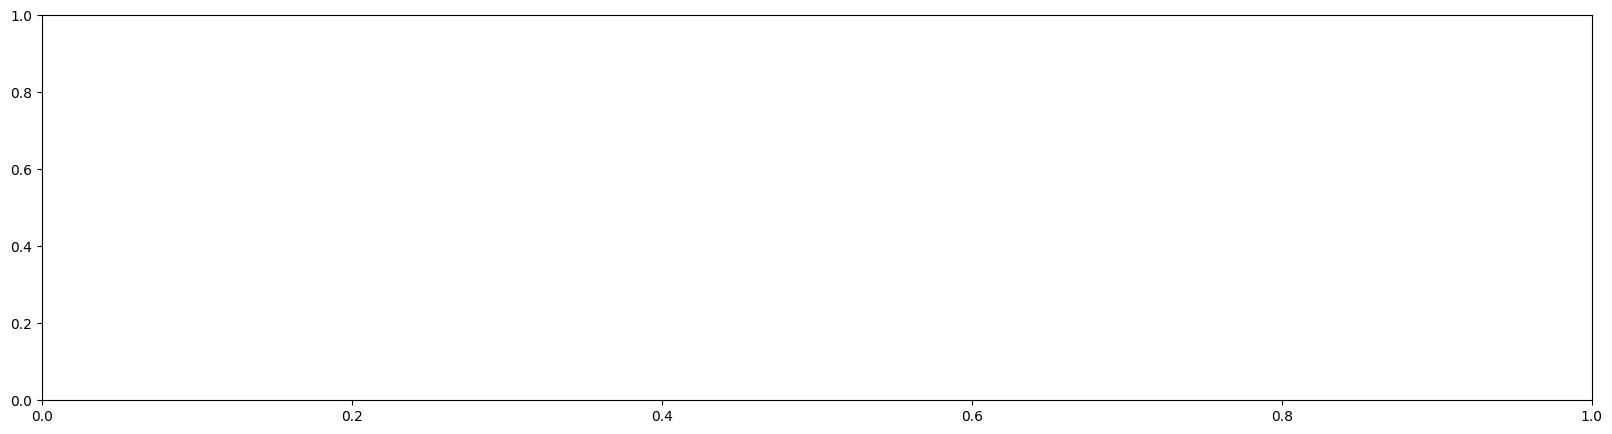

In [16]:
# policy_loss_log
# value_loss_log
# entropy_loss_log

fig, ax = plt.subplots(1,1, figsize = (20,5))
sns.lineplot([i.item() for i in value_loss_log])

# Deploy

In [14]:
import os

In [16]:
# model = ppo(N_PLAYER).to(device)
# model.load_state_dict(torch.load('/kaggle/input/ppo_3/pytorch/default/1/model_state_3.pth'))

/tmp/ipykernel_31/1658644612.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/ppo_3/pytorch/default/1/model_state_3.pth'))

<All keys matched successfully>

In [79]:
model = ppo(N_PLAYER).to(device)
path = f'/kaggle/working/model_new_arc_complex_rwd_50_iter.pth'
model.load_state_dict(torch.load(path))

/tmp/ipykernel_31/4181618562.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [84]:
move_encode = {"0": "pass",
                "1": "take"}
nothanks = nothanks_ppo()
human_index = 5

while nothanks.is_continue:
    print('------------------------------')
    print(f'''Card: {nothanks.current_card} | Chip in pot: {nothanks.chip_in_pot} | Player: {nothanks.turn} - {nothanks.players[nothanks.turn]}\n'''
)
    print('------------------------------')
    if nothanks.turn == human_index:
        move = move_encode.get(input("""Your turn:
0: pass
1: take
Enter here: """))
    else:
        with torch.no_grad():
            current_state = torch.tensor(nothanks.encode_state()).to(device)
            legal_move = nothanks.get_legal_action() # a list 
            legal_move_mask = torch.tensor([False if move in legal_move else True for move in nothanks.move_encode.values()]).to(device)
            move_raw, log_prob, entropy, value = model.forward(current_state, legal_move_mask)
            move = nothanks.move_encode.get(move_raw.item())
    print(f'Move taken: {move}')
    nothanks.action(move)

------------------------------
Card: 30 | Chip in pot: 0 | Player: 0 - Chip: 11 | Card owned: []

------------------------------
Move taken: pass
------------------------------
Card: 30 | Chip in pot: 1 | Player: 1 - Chip: 11 | Card owned: []

------------------------------
Move taken: pass
------------------------------
Card: 30 | Chip in pot: 2 | Player: 2 - Chip: 11 | Card owned: []

------------------------------
Move taken: pass
------------------------------
Card: 30 | Chip in pot: 3 | Player: 0 - Chip: 10 | Card owned: []

------------------------------
Move taken: pass
------------------------------
Card: 30 | Chip in pot: 4 | Player: 1 - Chip: 10 | Card owned: []

------------------------------
Move taken: pass
------------------------------
Card: 30 | Chip in pot: 5 | Player: 2 - Chip: 10 | Card owned: []

------------------------------
Move taken: take
------------------------------
Card: 8 | Chip in pot: 0 | Player: 2 - Chip: 15 | Card owned: [30]

-------------------------

In [85]:
for player_tmp in nothanks.players:
    print(player_tmp.calculate_score())

-72
-62
-82


In [94]:
nothanks.calculate_ranking()

[-20.0, 20.0, 0.0]

In [94]:
import os

In [95]:
os.getcwd()

'/kaggle/working'

In [96]:
output = os.getcwd()

In [111]:
torch.save(model.state_dict(), './model_new_arc_default_rwd_30_iter.pth')

In [179]:
torch.log(model.policy(current_state))

tensor([3.2157,    nan], device='cuda:0', grad_fn=<LogBackward0>)

In [183]:
logit = model.get_policy(current_state, legal_move_mask)

In [195]:
nn.Softmax()(logit)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([1.0000e+00, 9.3703e-23], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [185]:
prob = Categorical(logits = logit)

In [189]:
move = prob.sample()
move

tensor(0, device='cuda:0')

# Pitting

In [52]:
import os

In [103]:
model_prefix = 'model_gen_3_default_rwd'
# model_list = [i for i in os.listdir('/kaggle/working') if i.startswith(model_prefix)]
model_list = ['model_gen_3_default_rwd_50_iter.pth',
              'model_gen_3_default_rwd_60_iter.pth',
              'model_gen_3_default_rwd_80_iter.pth',
              'model_new_arc_complex_rwd_80_iter.pth',
              'model_new_arc_complex_rwd_50_iter.pth',
              'model_new_arc_complex_rwd_20_iter.pth',
             ]
model_name_dict = {a:b for a, b in enumerate(model_list)}
n_model = len(model_name_dict)

In [104]:
select_record = {i:0 for i in range(n_model)}
win_record = {i:0 for i in range(n_model)}
move_encode = {"0": "pass",
                "1": "take"}

n_match = 500

In [105]:
for _ in tqdm(range(n_match)):
    
    model_index = random.sample(range(n_model), k = 3)        
    for index in model_index:
        select_record[index] += 1
    model_list = []
    for index in model_index:
        model = ppo(N_PLAYER).to(device)
        path = f'/kaggle/working/{model_name_dict.get(index)}'
        model.load_state_dict(torch.load(path))
        model_list.append(model)
    
    
    nothanks = nothanks_ppo()
    while nothanks.is_continue:
        with torch.no_grad():
            current_state = torch.tensor(nothanks.encode_state()).to(device)
            legal_move = nothanks.get_legal_action() # a list 
            legal_move_mask = torch.tensor([False if move in legal_move else True for move in nothanks.move_encode.values()]).to(device)
            move_raw, log_prob, entropy, value = model_list[nothanks.turn].forward(current_state, legal_move_mask)
            move = nothanks.move_encode.get(move_raw.item())
        nothanks.action(move)    
    
    winner_index = np.argmax(nothanks.calculate_ranking())
    win_record[model_index[winner_index]] += 1

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_31/2851337586.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
100%|███████

In [111]:
pd.DataFrame([select_record, win_record]).T\
.rename(columns = {0: 'total',
         1: 'win'
        })\
.assign(win_pct = lambda df: df['win']/df['total'])\
.sort_values('win_pct', ascending = False)\
.reset_index()\
.assign(model_name = lambda df: df['index'].apply(lambda x: model_name_dict.get(x)))

,index,total,win,win_pct,model_name
0,1,236,97,0.411017,model_gen_3_default_rwd_60_iter.pth
1,0,248,97,0.391129,model_gen_3_default_rwd_50_iter.pth
2,3,245,85,0.346939,model_new_arc_complex_rwd_80_iter.pth
3,2,265,89,0.335849,model_gen_3_default_rwd_80_iter.pth
4,5,242,64,0.264463,model_new_arc_complex_rwd_20_iter.pth
5,4,264,68,0.257576,model_new_arc_complex_rwd_50_iter.pth


In [109]:
model_name_dict.get(3)

'model_new_arc_complex_rwd_80_iter.pth'

In [35]:
param_record[4]

{'learning_rate': 0.0005,
 'e': 0.2,
 'value_coef': 0.6,
 'entropy_coef': 0.01,
 'index': 4}

In [36]:
param_record

[{'learning_rate': 0.0005,
  'e': 0.3,
  'value_coef': 0.5,
  'entropy_coef': 0.01,
  'index': 0},
 {'learning_rate': 0.001,
  'e': 0.3,
  'value_coef': 0.7,
  'entropy_coef': 0.03,
  'index': 1},
 {'learning_rate': 0.0005,
  'e': 0.1,
  'value_coef': 0.7,
  'entropy_coef': 0.02,
  'index': 2},
 {'learning_rate': 0.0007,
  'e': 0.2,
  'value_coef': 0.6,
  'entropy_coef': 0.03,
  'index': 3},
 {'learning_rate': 0.0005,
  'e': 0.2,
  'value_coef': 0.6,
  'entropy_coef': 0.01,
  'index': 4},
 {'learning_rate': 0.0005,
  'e': 0.3,
  'value_coef': 0.5,
  'entropy_coef': 0.02,
  'index': 5},
 {'learning_rate': 0.0002,
  'e': 0.2,
  'value_coef': 0.5,
  'entropy_coef': 0.01,
  'index': 6},
 {'learning_rate': 0.001,
  'e': 0.3,
  'value_coef': 0.6,
  'entropy_coef': 0.01,
  'index': 7},
 {'learning_rate': 0.001,
  'e': 0.2,
  'value_coef': 0.6,
  'entropy_coef': 0.02,
  'index': 8},
 {'learning_rate': 0.0002,
  'e': 0.2,
  'value_coef': 0.6,
  'entropy_coef': 0.02,
  'index': 9}]